## Importing Libraries

In [ ]:
# <==== Importing Neccesary libraries ===>
import os
import numpy as np
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from PIL import Image
import random
from random import shuffle
import cv2
from tqdm import tqdm
from PIL import Image
from random import shuffle
from scipy import interp
from itertools import cycle

# <==== Tensorflow & Machine Learning lib ===>
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# <==== Performance Metrics ===>
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [ ]:
# setting path of directory
B_DIR = "ISIC_2019_ML/Bcc"
M_DIR = "ISIC_2019_ML/Melanoma"
N_DIR = "ISIC_2019_ML/Navus"
I_dir = "ISIC_2019_ML"
I_Var = "ISIC_2019_ML/isic_vars"

In [ ]:
# loading the saved variables
x_train = np.load(I_Var+"/x_train.npy")
y_train = np.load(I_Var+"/y_train.npy")
x_test = np.load(I_Var+"/x_test.npy")
y_test = np.load(I_Var+"/y_test.npy")
num_classes = np.load(I_Var+"/num_classes.npy")
len_data = np.load(I_Var+"/len_data.npy")
train_len = np.load(I_Var+"/train_len.npy")
test_len = np.load(I_Var+"/test_len.npy")

reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
# ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,           # Randomly rotate images
    width_shift_range=0.2,       # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,      # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,             # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,              # Randomly zoom images
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Points outside the boundaries of the input are filled according to the given mode
)

# Create an ImageDataGenerator without data augmentation for validation
val_datagen = ImageDataGenerator()

# Fit the generators on your data
train_datagen.fit(x_train)       # Fit the training data
val_datagen.fit(x_test)         # Fit the validation data

## Model Building

In [ ]:
# Set up callbacks
# Stop training when a val_loss has stopped improving for a specified patience = 3.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ModelCheckpoint: Save the model after every epoch if the val_loss has improved.
model_checkpoint = ModelCheckpoint('skin_cancer_model_v2.h5', save_best_only=True)

# Reduce learning rate when a metric val_loss has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)

# Train the model using data augmentation
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    epochs=20,
    validation_data=val_datagen.flow(x_test, y_test),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
304/304 [==============================] - 516s 2s/step - loss: 0.8016 - accuracy: 0.6357 - val_loss: 0.7095 - val_accuracy: 0.6836
Epoch 2/20
304/304 [==============================] - 510s 2s/step - loss: 0.7627 - accuracy: 0.6561 - val_loss: 0.6935 - val_accuracy: 0.6823
Epoch 3/20
304/304 [==============================] - 526s 2s/step - loss: 0.7432 - accuracy: 0.6649 - val_loss: 0.6800 - val_accuracy: 0.6918
Epoch 4/20
304/304 [==============================] - 519s 2s/step - loss: 0.7345 - accuracy: 0.6738 - val_loss: 0.6809 - val_accuracy: 0.6939
Epoch 5/20
304/304 [==============================] - 513s 2s/step - loss: 0.7229 - accuracy: 0.6754 - val_loss: 0.6693 - val_accuracy: 0.6951
Epoch 6/20
304/304 [==============================] - 513s 2s/step - loss: 0.7178 - accuracy: 0.6803 - val_loss: 0.6671 - val_accuracy: 0.6984
Epoch 7/20
304/304 [==============================] - 527s 2s/step - loss: 0.7105 - accuracy: 0.6803 - val_loss: 0.6677 - val_accuracy: 0.6972

In [ ]:
# Save the trained model
model.save('skin_cancer_model_v2.h5')

In [ ]:
# Load model
model = load_model(I_dir+'/skin_cancer_model_v2.h5')

## Model Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

76/76 [==============================] - 22s 274ms/step - loss: 0.6233 - accuracy: 0.7186
Test Loss: 0.6233, Test Accuracy: 0.7186


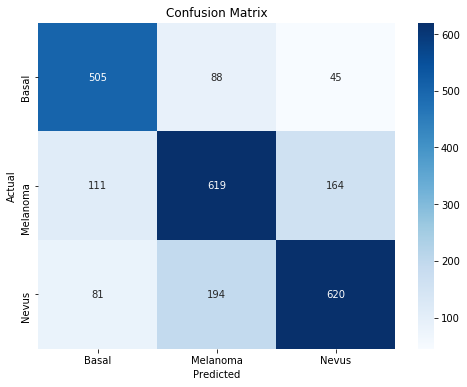

Classification Report:
             precision    recall  f1-score   support

          0       0.72      0.79      0.76       638
          1       0.69      0.69      0.69       894
          2       0.75      0.69      0.72       895

avg / total       0.72      0.72      0.72      2427



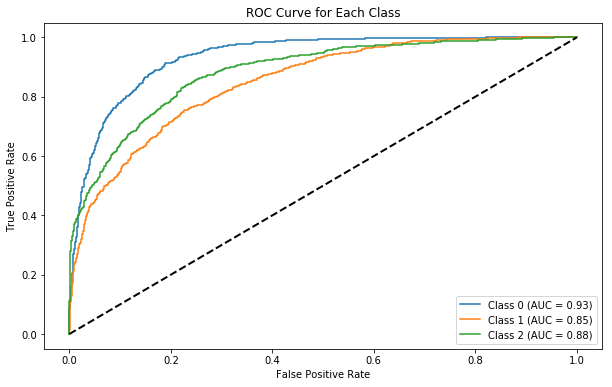

Weighted Precision: 0.7193
Weighted Recall: 0.7186
Weighted F1 Score: 0.7182


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Basal', 'Melanoma', 'Nevus'], yticklabels=['Basal', 'Melanoma', 'Nevus'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(class_report)

# ROC Curve
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# Precision, Recall, F1 Score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')
print(f'Weighted F1 Score: {f1:.4f}')


testing the modified CNN on a small subset of data

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Set the path to the new dataset directory
F_DIR = "ISIC_2019_ML/Test_Data_3"

In [ ]:
#Testing -  Load model
model = load_model('skin_cancer_model.h5')

In [ ]:
# Read and preprocess the new dataset
new_data = []

# Iterate through the files in the new dataset directory
for filename in os.listdir(F_DIR):
    try:
        image_path = os.path.join(F_DIR, filename)
        image = cv2.imread(image_path)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        new_data.append(np.array(size_image))
        print(filename)
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

bcc_ISIC_0028457.jpg
bcc_ISIC_0028486.jpg
bcc_ISIC_0028495.jpg
bcc_ISIC_0028653.jpg
bcc_ISIC_0028670.jpg
bcc_ISIC_0028671.jpg
melanoma_ISIC_0001152_downsampled.jpg
melanoma_ISIC_0009868.jpg
melanoma_ISIC_0009950.jpg
melanoma_ISIC_0009955.jpg
nvl_ISIC_0010249.jpg
nvl_ISIC_0010255.jpg
nvl_ISIC_0010348.jpg
nvl_ISIC_0010357.jpg


In [ ]:
# Convert the list to a numpy array
new_data = np.array(new_data)

# Normalize the new dataset
new_data = new_data.astype('float32') / 255

In [ ]:
# Make predictions on the new dataset
new_predictions = model.predict(new_data)

In [ ]:
# Convert the predictions to class labels
predicted_labels = np.argmax(new_predictions, axis=1)

In [ ]:
# Print the predicted labels or perform further analysis as needed
print("Predicted Labels:", predicted_labels)

Predicted Labels: [0 2 0 2 0 0 1 2 2 2 1 2 2 2]


In [ ]:
true_labels_CN1 = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])

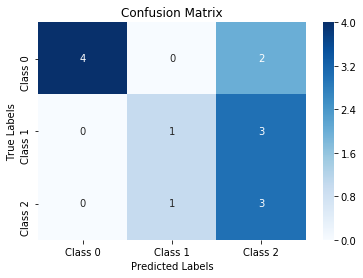

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels_CN1, predicted_labels)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

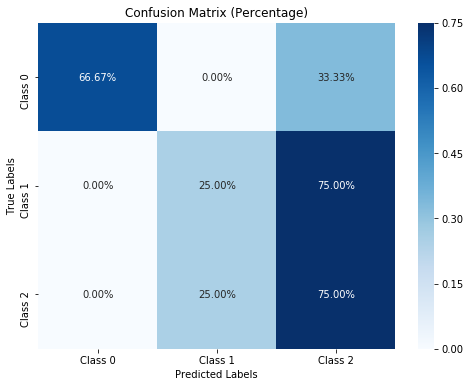

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels_CN1, predicted_labels)

# Convert to percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap with annotations and percentage format
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])

plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Classification Report
class_names = ["Class 0", "Class 1", "Class 2"]
report = classification_report(true_labels_CN1, predicted_labels, target_names=class_names)

print("Classification Report:")
print(report)

Classification Report:
             precision    recall  f1-score   support

    Class 0       1.00      0.67      0.80         6
    Class 1       0.50      0.25      0.33         4
    Class 2       0.38      0.75      0.50         4

avg / total       0.68      0.57      0.58        14



In [ ]:
# Calculate the overall accuracy
overall_accuracy = accuracy_score(true_labels_CN1, predicted_labels)

# Print the overall accuracy
print(f'Overall Accuracy: {overall_accuracy:.4f}')

Overall Accuracy: 0.5714


In [ ]:
# Stopped testing on this model, as there is no improvement in the result and performance metrics.